Projet sur la prédiction du risque d'abandon scolaire


In [146]:
# Imports nécéssaires
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from  sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, confusion_matrix
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Etape 1: Chargement du Dataset et premières infos

In [7]:
df_abandon = pd.read_csv("Dataset_Abandon_Scolaire.csv")
df_abandon.info()
df_abandon.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  2000 non-null   int64  
 1   Sexe                 2000 non-null   object 
 2   Taux_presence        2000 non-null   float64
 3   Nombre_retards       2000 non-null   int64  
 4   Note_moyenne         2000 non-null   float64
 5   Situation_familiale  2000 non-null   object 
 6   Abandon              2000 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 109.5+ KB


,Age,Sexe,Taux_presence,Nombre_retards,Note_moyenne,Situation_familiale,Abandon
0,21,Femme,89.585023,2,15.826896,Enfants à charge,0
1,20,Homme,70.713068,3,12.829358,Célibataire,0
2,22,Femme,82.122963,1,13.086319,Enfants à charge,0
3,24,Homme,87.408859,3,14.992032,Célibataire,0
4,20,Homme,86.470676,3,12.671649,Marié,0


On voit que le jeux de donnée contien au total 7 colonnes, dont 5 qui sont numériques et 2 qui sont des objets, des chaines de caractères, "Sexe" et "Situation familiale.

In [8]:
df_abandon.isnull().sum().sum()
df_abandon["Abandon"].value_counts()

Abandon
0    1832
1     168
Name: count, dtype: int64

Grâce a la premiére ligne, on compte le nombre totam de valeurs manquantes dans le DF, il n'y en a aucune.
La deuxième ligne nous permet de savoir combien de personnes ont abandonné leurs études, elles sont 168, a peu près 8,4% de l'ensemble des personnes. 
Cette colonne "Target" n'est donc pas balancé et ne nous permet pas de l'utiliser afin d'avoir de bonnesmetrics par la suite.

Etape 2: Normalisation de la donnée et utilisation SentenceTransformer pour tarnsformer les valeurs non numériques en vecteurs

In [34]:

problem = df_abandon.drop("Abandon", axis=1)
solution = df_abandon["Abandon"]

model = SentenceTransformer("dangvantuan/sentence-camembert-base")
embeddings_sexe = model.encode(problem["Sexe"])
embeddings_situation = model.encode(problem["Situation_familiale"])

sim_sexe = cosine_similarity([embeddings_sexe[0]], [embeddings_sexe[1]])
sim_situation = cosine_similarity([embeddings_situation[0]], [embeddings_situation[1]])
print(f"Similarité cosine du sexe: {sim_sexe[0][0]:.4f}")
print(f"Similarité cosine de la situation familiale: {sim_situation[0][0]:.4f}")

embedding_cols = [f"Sexe_embed_{i}" for i in range(embeddings_sexe.shape[1])]
df_embeddings_sexe = pd.DataFrame(embeddings_sexe, columns=embedding_cols)
embedding_cols_situation = [f"Situation_embed_{i}" for i in range(embeddings_situation.shape[1])]
df_embeddings_situation = pd.DataFrame(embeddings_situation, columns=embedding_cols_situation)

problem = problem.drop("Sexe", axis=1)
problem = pd.concat([problem, df_embeddings_sexe], axis=1)
problem = problem.drop("Situation_familiale", axis=1)
problem = pd.concat([problem, df_embeddings_situation], axis=1)


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sebas\.cache\huggingface\hub\models--dangvantuan--sentence-camembert-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Similarité cosine du sexe: 1.0000
Similarité cosine de la situation familiale: 0.3148


SentenceTransformer nous permet de transformer les valeurs alphanumériques en en vecteurs.

In [40]:
problem.head()
problem.info()
print(problem.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 1540 entries, Age to Situation_embed_767
dtypes: float32(1536), float64(2), int64(2)
memory usage: 11.8 MB
Age                      15
Taux_presence          1947
Nombre_retards           10
Note_moyenne           2000
Sexe_embed_0              2
                       ... 
Situation_embed_763       4
Situation_embed_764       5
Situation_embed_765       4
Situation_embed_766       5
Situation_embed_767       4
Length: 1540, dtype: int64


Nous avons maintenant un Data Frame avec le total des colonnes qui sont en des valeurs numériques 

Etape 3 : Corrélation

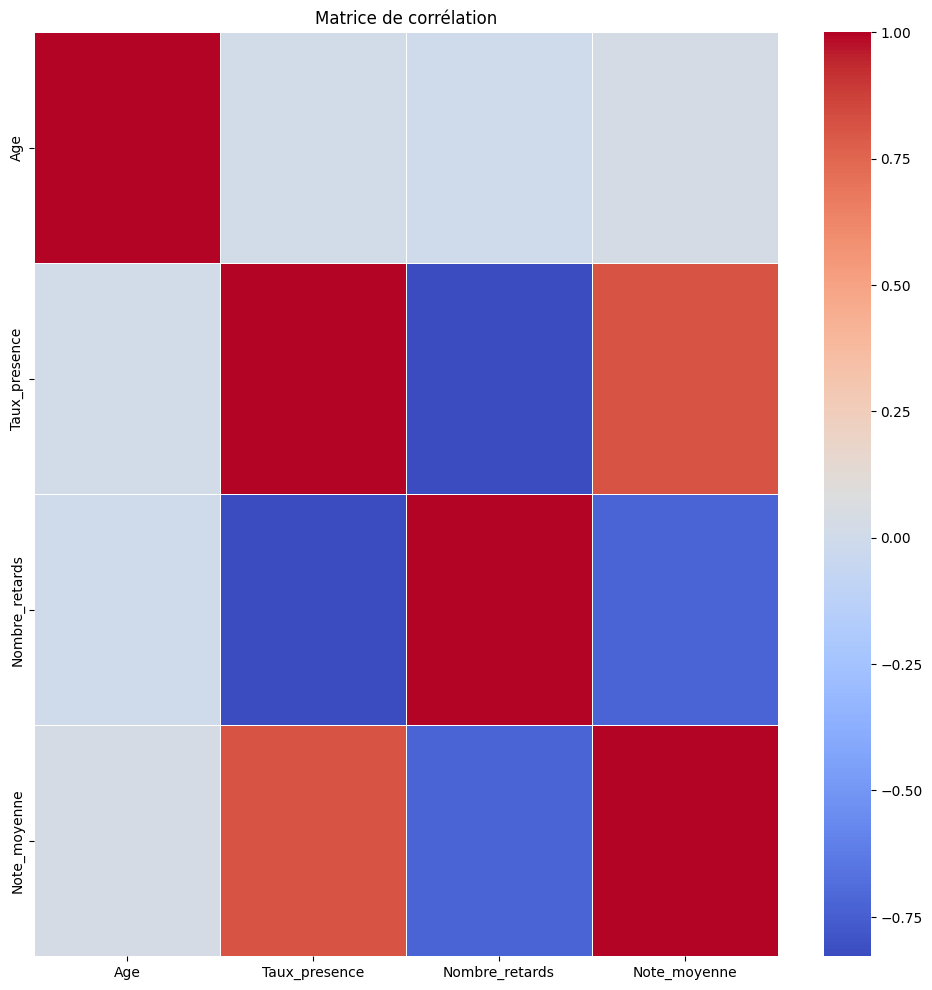

In [49]:
df_clean = problem.loc[:, problem.nunique() > 5]

corr_matrix = df_clean.corr()
plt.figure(figsize=(12,12))
seaborn.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5 )
plt.title("Matrice de corrélation")
plt.show()

Cetre matrice de corrélation où on a enlever les colonnes à variance nulle, nous montre qu'il n'ya pas beaucoup de corrélation entre les différentes colonnes, seulement entre le taux de présence et la note moyenne.

Etape 4: Normalisation et PCA

In [139]:
standard_scaler = StandardScaler()
normalized_problem = standard_scaler.fit_transform(problem)

pca_object = PCA(2)
principal_components = pca_object.fit_transform(normalized_problem)


In [80]:
explained_variance = pca_object.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

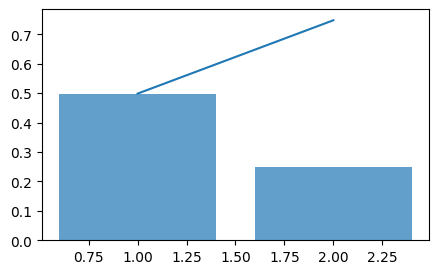

In [81]:
plt.figure(figsize=(5,3))
plt.bar(range(1,len(explained_variance) + 1),explained_variance,alpha=0.7,label='explained_variance')
plt.plot(range(1,len(cumulative_variance) + 1),cumulative_variance, label='cumulative_variance')
plt.show()

Ce bar plot, nous permet de voir q'avec 2 composantes principale contient 80 % l'intégralité de l'information du Data Set. 

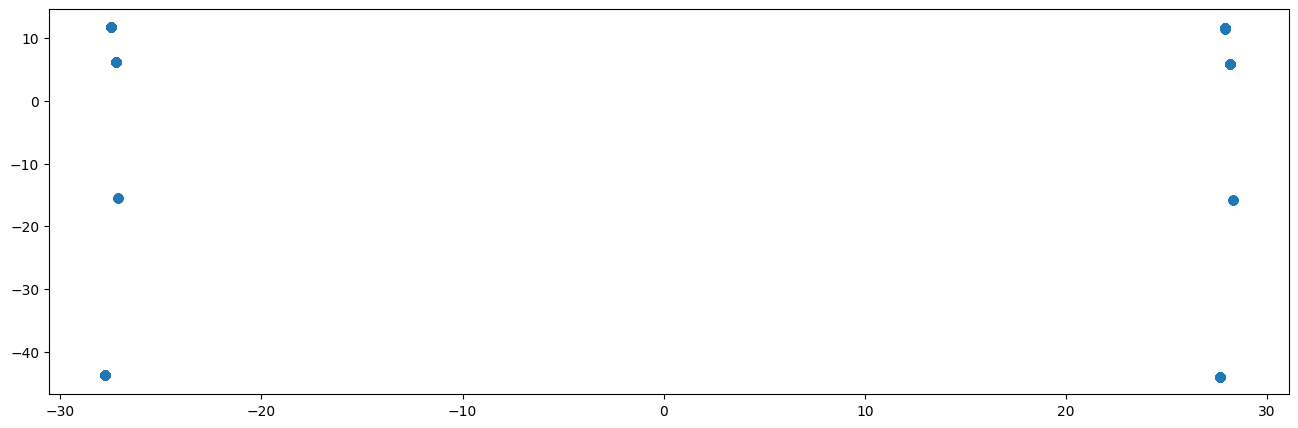

In [108]:
plt.figure(figsize=(16,5))
plt.plot(principal_components[:,0], principal_components[:,1], "o")
plt.show()

Etape 5: Elbow Method, K-Means

In [138]:
train_x, test_x, y_train, y_test = train_test_split(normalized_problem, solution)

In [95]:
def elbow_method(train_x):
    k_values = []
    variance_per_k = []
    for k in range(1,10):
        k_means_objetc= KMeans(n_clusters = k)
        k_means_objetc.fit(train_x)
        k_values.append(k)
        variance_per_k.append(k_means_objetc.inertia_)

    plt.figure(figsize=(10,15))
    plt.plot(k_values, variance_per_k, "o:")
    plt.show()

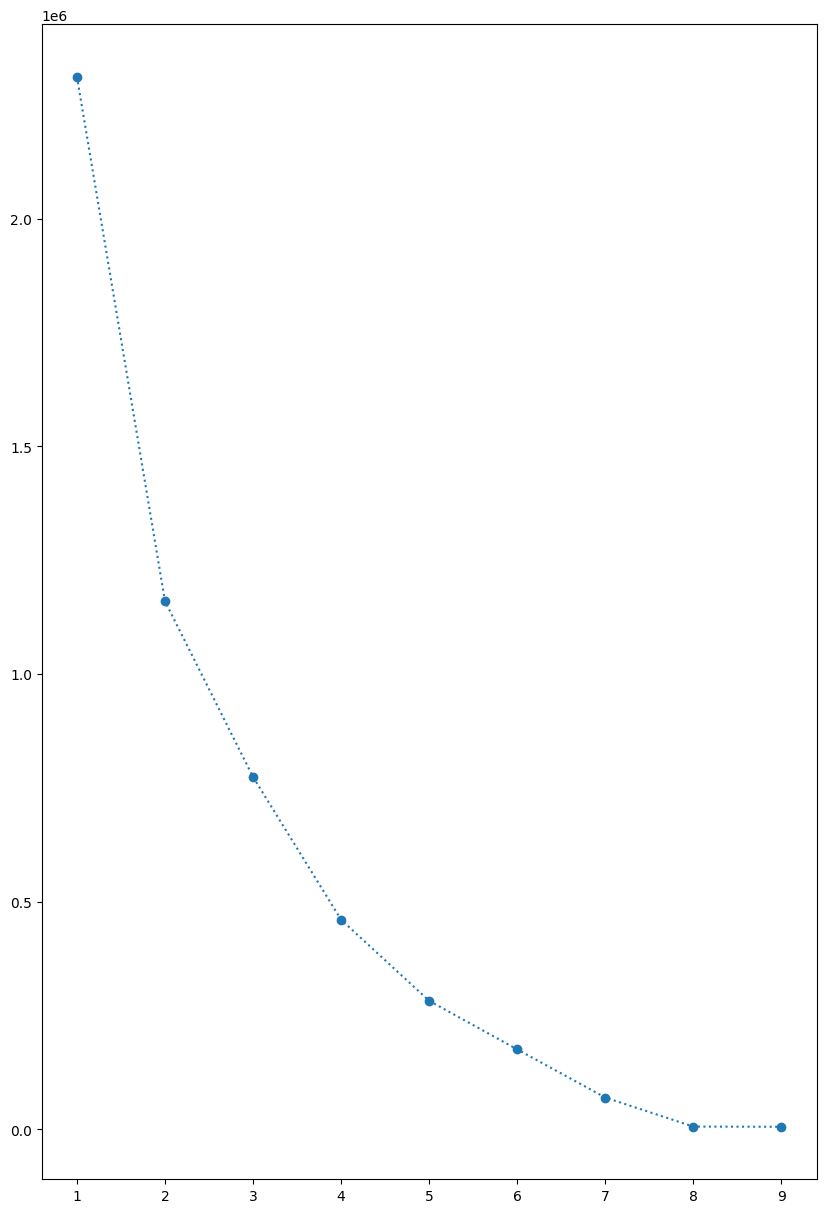

In [96]:
elbow_method(train_x)

La méthode du coude, nous permet de voir qu'il y a 4 OU 5 clusters dans l'ensemble du Data Set.

In [103]:
k_means_object = KMeans(n_clusters=4)
k_means_object.fit(train_x)
clusters = k_means_object.predict(train_x)

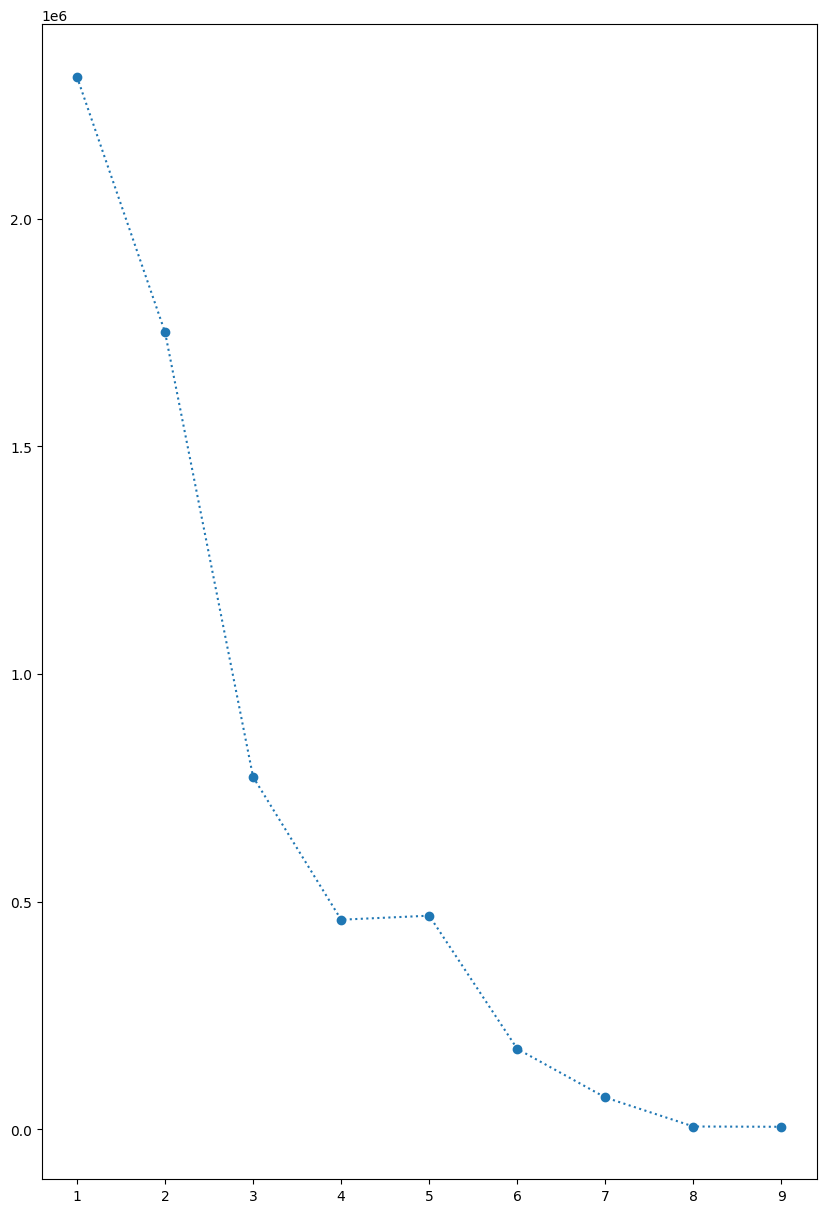

In [104]:
elbow_method(train_x)

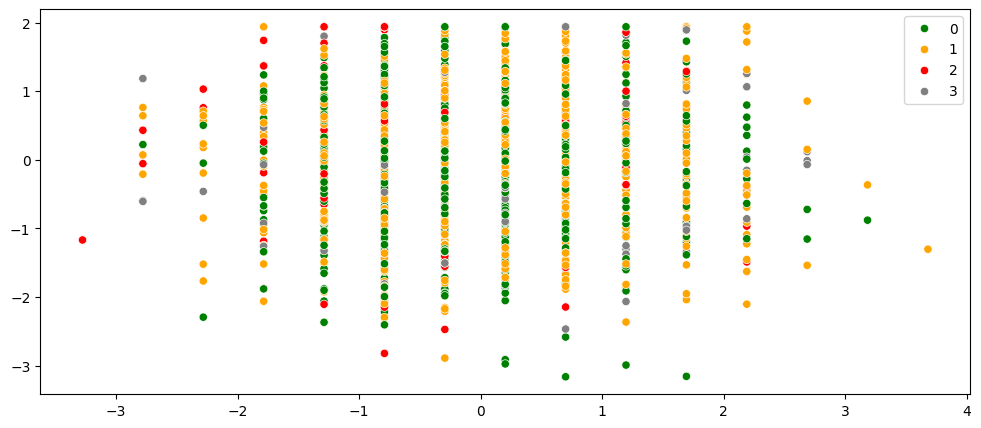

In [105]:
plt.figure(figsize=(12,5))
custom_palette = {0 : "green", 1:"orange", 2:"red", 3:"grey"}
seaborn.scatterplot(x=train_x[:,0], y=train_x[:,1], hue=clusters, palette=custom_palette)
plt.show()

La superposition des points ne nous permet pas d'identifier de bons clusters.

In [125]:
comparison_df = pd.DataFrame({
    "Cluster": clusters,
    "Abandon": y_train
})

print(pd.crosstab(comparison_df["Abandon"], comparison_df["Cluster"]))

Cluster    0    1   2    3
Abandon                   
0        584  598  89  104
1         46   40  24   15


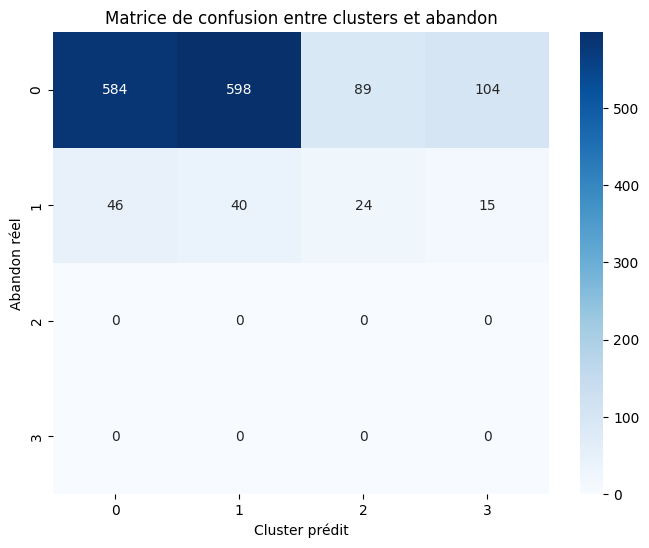

In [129]:
conf_mat = confusion_matrix(y_train, clusters)

plt.figure(figsize=(8,6))
seaborn.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Cluster prédit")
plt.ylabel("Abandon réel")
plt.title("Matrice de confusion entre clusters et abandon")
plt.show()

Voici le résultat de notre K-Means, qui nous montre que la majorité de nos 4 clusters n'abandonnent pas, sur l'ensembles des clusters entre 6 et 8 % de personnes n'abandonnent pas, comme lors de la première analyse. 
La distribution de la variable Abandon est très déséquilibrée (très peu de 1 par rapport aux 0).

KNN

In [147]:
def get_optimal_k_value(normalized_problem, solution):
    n_folds = 5
    parameters = {"n_neighbors" : np.arange(1, 52, 2)}
    grid_search_object = GridSearchCV(KNeighborsClassifier(),
                                    parameters,
                                     cv=n_folds,
                                     scoring="f1_macro")
    
    grid_search_object.fit(normalized_problem, solution)
    print(grid_search_object.best_params_)
    best_model = grid_search_object.best_estimator_
    scores = pd.DataFrame(grid_search_object.cv_results_)
    return best_model, scores

In [148]:
scores = get_optimal_k_value(normalized_problem, solution)
print(scores)

{'n_neighbors': 5}
(KNeighborsClassifier(),     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.055197      0.026910         0.214031        0.297149   
1        0.050453      0.004545         0.080668        0.013344   
2        0.049202      0.005601         0.084000        0.043278   
3        0.043439      0.004948         0.092058        0.067398   
4        0.046998      0.003796         0.064602        0.003722   
5        0.047324      0.001746         0.065391        0.007356   
6        0.046801      0.002925         0.091718        0.037886   
7        0.046640      0.003157         0.063857        0.001792   
8        0.055626      0.006055         0.080005        0.008488   
9        0.051844      0.002046         0.090783        0.022167   
10       0.051001      0.001551         0.076202        0.007631   
11       0.052203      0.003485         0.099882        0.041594   
12       0.050188      0.003117         0.072785        0.007969   
13  

Le KNN nous donne que le nombre de voisins idéale pour identifier les clusters est de 5.

In [150]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_x, y_train)

KNeighborsClassifier()

In [155]:
distances, indices = knn.kneighbors([test_x[2]])
print(distances[0])
print(indices[0])
for indice in indices[0]:
    print(y_train.iloc[indice])

[0.59639381 1.15474768 1.23019425 1.23933205 1.24185708]
[1238 1147 1326   13  796]
0
0
1
0
0


In [161]:
y_pred = knn.predict(test_x)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       461
           1       0.66      0.54      0.59        39

    accuracy                           0.94       500
   macro avg       0.81      0.76      0.78       500
weighted avg       0.94      0.94      0.94       500



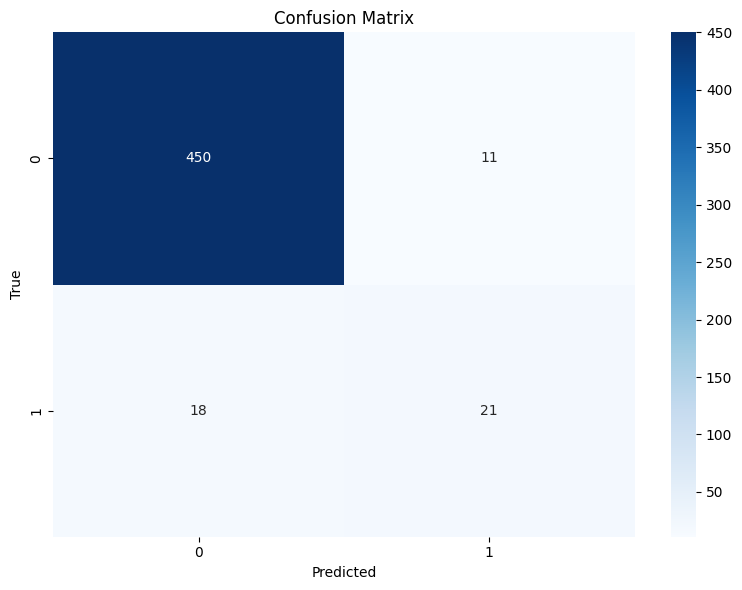

In [162]:
cm = confusion_matrix(y_test, y_pred)

# Beautiful Confusion Matrix
plt.figure(figsize=(8,6))
seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

Ces 2 modèles nous présentes des similarités, il est difficile de prédire les abandons car dans l'ensemble du Data set cette taget n'est pas bien balancé.
Les métrics du KNN nous montre un recall très bas pour les cas ou les personnes abandonnent ainsi que le F1-Score ce qui veut dire que le modèle a une mauvaise prédiction du au balencement.
Le KNN montre également une plus grande imprécision que le K-Means
